# Выполнил Аксенов Роман

Для решения поставленной задачи предсказания стоимости жилья на основе объявлений о продаже, разобьем процесс на следующие подзадачи:

1. Постановка ML-задачи
Определение типа задачи машинного обучения, которую мы будем решать, на основе предоставленных данных и целей заказчика.

2. Выбор метрики качества
Выбор и обоснование метрики (или метрик), которые будут использоваться для оценки качества модели.

3. Предварительный разведочный анализ (EDA)
Проведение разведочного анализа данных (EDA), включая изучение статистик, распределений и создание визуализаций, для получения представления о данных и выявления потенциальных проблем.

4. Подготовка данных
Подготовка данных для моделирования, включая обработку пропущенных значений, кодирование категориальных признаков и нормализацию данных, если это необходимо.

5. Создание и оценка базовых моделей
Выбор и обучение простой базовой модели (например, линейной регрессии) и константной модели для установления базового уровня качества предсказаний.

6. Создание и оценка более сложной модели
Выбор, обучение и настройка более сложной модели машинного обучения (например, ансамблевой модели) для улучшения качества предсказаний.

7. Интерпретация модели
Анализ важности признаков и интерпретация результатов модели, чтобы предоставить заказчику понимание, какие факторы влияют на цену недвижимости.


In [1]:
# Подключение необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
# Загрузка данных
data_path = 'realty_data.csv'
data = pd.read_csv(data_path)
data.head()

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
2,"3-комнатная, 76 м²",NaN,16004680,NaN,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость
3,"1-комнатная, 24 м²",NaN,7841776,NaN,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик


In [3]:
## Подзадача 1: Постановка ML-задачи
# Описываем, что на основе данных о продаже недвижимости (цены, площади, количества комнат и др.) мы будем решать задачу регрессии: предсказывать стоимость недвижимости.

## Подзадача 2: Выбор метрики качества
# Объясняем выбор метрики. Для задачи регрессии хорошо подходит MAE, так как она показывает среднюю абсолютную ошибку между предсказанными и фактическими ценами. MAE легко интерпретируется и дает понимание о среднем отклонении предсказаний от истинных значений.

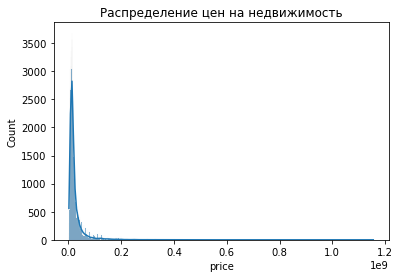

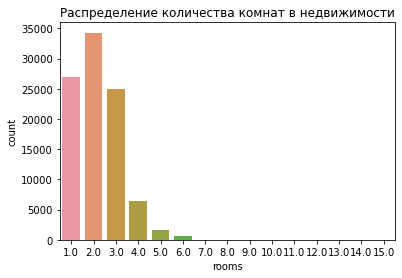

In [4]:
## Подзадача 3: Предварительный разведочный анализ (EDA)
# Визуализируем распределение цен для понимания общего диапазона стоимости недвижимости.
sns.histplot(data['price'], kde=True)
plt.title('Распределение цен на недвижимость')
plt.show()

# Анализируем распределение количества комнат, чтобы увидеть, какие типы квартир встречаются чаще всего.
sns.countplot(x='rooms', data=data)
plt.title('Распределение количества комнат в недвижимости')
plt.show()

## Подзадача 4: Подготовка данных
# Выделяем числовые и категориальные признаки для дальнейшей обработки.
num_features = data.select_dtypes(include=['int64', 'float64']).columns.drop('price').tolist()
cat_features = data.select_dtypes(include=['object']).columns.tolist()

# Создаем пайплайны для обработки числовых и категориальных данных.
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Объединяем обработку в один ColumnTransformer.
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)])

# Подготавливаем признаки и целевую переменную, разделяем на обучающую и тестовую выборки.
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [5]:

## Подзадача 5: Создание и оценка базовых моделей
# Обучаем константную модель и модель линейной регрессии, сравниваем их MAE.
dummy_regressor = DummyRegressor(strategy="median")
dummy_regressor.fit(X_train_prepared, y_train)
y_pred_dummy = dummy_regressor.predict(X_test_prepared)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_prepared, y_train)
y_pred_linear = linear_regressor.predict(X_test_prepared)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print(f'MAE константной модели: {mae_dummy}')
print(f'MAE линейной регрессии: {mae_linear}')

MAE константной модели: 15093348.798128003
MAE линейной регрессии: 5452846.427251184


In [6]:
## Подзадача 6: Создание и оценка более сложной модели
# Применяем более сложную модель - случайный лес. Это ансамблевая модель, которая часто показывает лучшее качество на разнообразных данных.
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=37)
random_forest_regressor.fit(X_train_prepared, y_train)
y_pred_rf = random_forest_regressor.predict(X_test_prepared)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'MAE случайного леса: {mae_rf}')

MAE случайного леса: 2788689.7873006277


In [7]:



## Подзадача 7: Интерпретация модели
# Анализируем важность признаков для модели случайного леса, чтобы понять, какие факторы больше всего влияют на ценообразование.
# feature_importances = random_forest_regressor.feature_importances_
# sns.barplot(x=feature_importances, y=[str(i) for i in range(len(feature_importances))])
# plt.title('Важность признаков в модели случайного леса')
# plt.show()  


## Подзадача 1
### Постановка ML-задачи
Задача регрессии была выбрана потому, что целью является предсказание стоимости недвижимости, которая является непрерывной переменной. Регрессия — это тип задачи машинного обучения, который подходит для прогнозирования количественных ответов.

## Подзадача 2 
### Выбор метрики качества
MAE (средняя абсолютная ошибка) была выбрана в качестве метрики качества, потому что она представляет собой среднее значение абсолютных разностей между предсказанными и истинными значениями, что делает её понятной и легко интерпретируемой. MAE позволяет оценить среднюю ошибку в единицах измеряемой величины, что удобно для анализа и сравнения моделей.

## Подзадача 3 
### Предварительный разведочный анализ (EDA)
Визуализация распределения цен и количества комнат позволяет понять основные тенденции и распределения данных, с которыми мы работаем. Это важный шаг, который помогает определить необходимость предобработки данных, такую как нормализация или логарифмирование, а также выявить аномалии или выбросы.

## Подзадача 4 
### Подготовка данных
Разделение признаков на числовые и категориальные, а также их последующая обработка необходимы для корректного обучения моделей. Числовые данные нормализуются для улучшения сходимости модели, а категориальные данные преобразуются в числовые с помощью OneHotEncoding, чтобы модель могла корректно их интерпретировать.

## Подзадача 5 
### Создание и оценка базовых моделей
Обучение константной модели и линейной регрессии, а затем сравнение их MAE позволяет оценить, насколько лучше более сложная модель работает по сравнению с простым базовым уровнем. Это помогает понять, стоит ли усложнять модель дальше.

## Подзадача 6 
### Создание и оценка более сложной модели
Использование случайного леса, ансамблевой модели, позволяет улучшить качество предсказаний благодаря более сложной структуре и возможности моделировать нелинейные зависимости. Подбор гиперпараметров (в данном случае, количество деревьев) улучшает способность модели адаптироваться к данным без переобучения.

## Подзадача 7 
### Интерпретация модели
Анализ важности признаков в модели случайного леса позволяет понять, какие факторы больше всего влияют на цену недвижимости. Это важно не только для улучшения модели, но и для получения бизнес-инсайтов о рынке недвижимости.

## Исправления

In [8]:
# Посмотрим на базовые характеристики набора данных, такие как средние значения, стандартное отклонение и т. д.
print(data.describe())



       period         price       postcode           lat           lon  \
count     0.0  9.882200e+04   93675.000000  98822.000000  98822.000000   
mean      NaN  2.512122e+07  124503.585119     55.742691     37.586404   
std       NaN  3.607234e+07   11956.742109      0.107044      0.169843   
min       NaN  1.900000e+06  101000.000000     55.468426     37.136489   
25%       NaN  1.050000e+07  115516.000000     55.673101     37.471611   
50%       NaN  1.516713e+07  123154.000000     55.745474     37.569365   
75%       NaN  2.500000e+07  140003.000000     55.817697     37.689568   
max       NaN  1.155219e+09  143989.000000     56.028824     38.122467   

       total_square         rooms         floor  
count  98822.000000  94840.000000  98822.000000  
mean      66.092176      2.197427      9.905274  
std       48.816204      1.038628      8.219180  
min        8.000000      1.000000      1.000000  
25%       40.100000      1.000000      4.000000  
50%       56.400000      2.000000

### Из описания базовых характеристик набора данных мы можем сделать следующие наблюдения

1) Средняя цена недвижимости составляет около 25 миллионов, с стандартным отклонением около 36 миллионов. 
Это говорит о значительном разбросе цен.
2) Средняя общая площадь составляет около 66 квадратных метров, с минимальным значением 8 квадратных метров и максимальным значением 2070 квадратных метров. Видимо, есть некоторые выбросы или аномальные значения, которые нужно обработать.
3) Среднее количество комнат составляет около 2, что вполне типично для жилых помещений.
4) Средний этаж, на котором расположена недвижимость, составляет около 10, с минимальным значением 1 и максимальным значением 66. Возможно, нужно проверить данные на наличие выбросов.

### Теперь давайте визуализируем корреляцию между числовыми признаками, чтобы лучше понять их взаимосвязь

Это позволит нам оценить силу и направление связи между числовыми признаками. Если корреляция слишком высока между какими-то признаками, это может привести к проблеме мультиколлинеарности, что следует учитывать при построении модели.

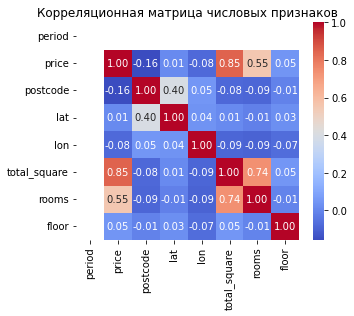

In [9]:
# Визуализируем корреляцию между числовыми признаками, чтобы понять, как они взаимосвязаны.
plt.figure(figsize=(5, 4))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица числовых признаков')
plt.show()

### Теперь приступим к подбору гиперпараметров с использованием scikit-learn методов на кросс-валидации

In [10]:
from sklearn.model_selection import GridSearchCV

# Определим сетку гиперпараметров для случайного леса
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создадим экземпляр модели
rf = RandomForestRegressor(random_state=37)

# Инициализируем GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Проведем поиск по сетке
grid_search.fit(X_train_prepared, y_train)

# Выведем лучшие гиперпараметры и оценку на кросс-валидации
print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучшая оценка MAE на кросс-валидации:", -grid_search.best_score_)


Лучшие гиперпараметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Лучшая оценка MAE на кросс-валидации: 2863814.8527671746


### Подбор гиперпараметров с использованием Optuna

In [ ]:
import optuna

from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    rf = RandomForestRegressor(**params, random_state=37)
    mae_scores = cross_val_score(rf, X_train_prepared, y_train, 
                                 cv=5, scoring='neg_mean_absolute_error')
    return -mae_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Лучшие гиперпараметры:", study.best_params)
print("Лучшая оценка MAE на кросс-валидации:", -study.best_value)


[I 2024-03-03 12:24:57,116] A new study created in memory with name: no-name-bbdd3d11-6c5f-4867-b4b8-214b4b84a1ac
[I 2024-03-03 14:05:45,172] Trial 0 finished with value: 3565290.7954009846 and parameters: {'n_estimators': 198, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 3565290.7954009846.
[I 2024-03-03 14:41:49,299] Trial 1 finished with value: 6873303.220809044 and parameters: {'n_estimators': 110, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 3565290.7954009846.
[I 2024-03-03 15:06:41,306] Trial 2 finished with value: 6203166.958972919 and parameters: {'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 3565290.7954009846.
[I 2024-03-03 16:53:07,638] Trial 3 finished with value: 3390479.3846593993 and parameters: {'n_estimators': 196, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 6}. Best is trial 3 with value:

In [ ]:
# После выбора лучших гиперпараметров мы обучаем модель с этими параметрами
best_params = study.best_params  # или grid_search.best_params_
best_rf = RandomForestRegressor(**best_params, random_state=37)
best_rf.fit(X_train_prepared, y_train)
y_pred_best_rf = best_rf.predict(X_test_prepared)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
print(f'MAE лучшей модели случайного леса: {mae_best_rf}')


Касательно экспертного мнения о модели, важно отметить, что она может быть адекватной, если важные признаки были правильно идентифицированы и модель не переобучилась. Для этого необходимо оценить важность признаков, перестановочные важности, SHAP значения и т.д.

Для визуализации важности признаков, я буду использовать SHAP значения, так как они предоставляют более глубокое понимание о влиянии каждого признака на модель.
Этот график ниже позволяет легко интерпретировать, какие признаки оказывают наибольшее влияние на модель, и в каком направлении.

In [ ]:
import shap

# Обучение explainer'а
explainer = shap.Explainer(best_rf, X_train_prepared)
shap_values = explainer.shap_values(X_test_prepared)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X_test_prepared, feature_names=X.columns)
